In [90]:
import xscen as xs
from xscen.config import CONFIG
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, box

# === Load configuration ===
xs.load_config("../paths_obs.yml", "../config_obs.yml", verbose=(__name__ == "__main__"), reset=True)
pcat = xs.ProjectCatalog(CONFIG["paths"]["project_catalog"])

# === Load AHCCD temperature and precipitation datasets ===
ds_ahccd = pcat.search(processing_level="extracted", source="AHCCD").to_dataset_dict()
ahccd_tas = ds_ahccd["GovCan_AHCCD_CAN_station-tas.Quebec.extracted.D"]
ahccd_pr = ds_ahccd["GovCan_AHCCD_CAN_station-pr.Quebec.extracted.D"]

# === Define REGION — choose one ===

# Option 1: Entirety of North America via bounding box (active)
#north_america_bbox = box(-170, 5, -30, 85)  # [min_lon, min_lat, max_lon, max_lat]
#region_gdf = gpd.GeoDataFrame(geometry=[north_america_bbox], crs="EPSG:4326")

# Option 2: Quebec outline shapefile
#region_gdf = gpd.read_file('../' + CONFIG["extract"]["reconstruction"]["extract_dataset"]["region"]["shape"])  # QC
#region_gdf = region_gdf.to_crs("EPSG:4326")

# Option 3: Quebec internal regions
region_gdf = gpd.read_file('.' + CONFIG["regional_mean"]["region"]["shape"])  # QC regions
region_gdf = region_gdf.to_crs("EPSG:4326")

# === General filtering helper ===
def within_region(lat, lon, polygon_gdf):
    points = gpd.GeoDataFrame(geometry=[Point(x, y) for x, y in zip(lon, lat)], crs="EPSG:4326")
    selected = gpd.sjoin(points, polygon_gdf, predicate="within", how="inner")
    return selected.geometry.y.values, selected.geometry.x.values


2025-07-31 15:22:34 INFO     xscen.config    Updated the config with ../paths_obs.yml.
2025-07-31 15:22:34 INFO     xscen.config    Updated the config with ../config_obs.yml.



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


In [91]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point

# === ISDv3.1 ===
df_isd = pd.read_csv(CONFIG["other_observations"]["ISD"]["hourly"] + "/2020/20200104.csv").dropna(subset=["lat", "lon"])
df_isd_tas = df_isd[(df_isd["12004"] != -99999.0) & (df_isd["212004"] == 0)]
df_isd_pr_day = df_isd[(df_isd["13023"] != -99999.0) & (df_isd["213023"] == 0)]
df_isd_pr_hr  = df_isd[(df_isd["13019"] != -99999.0) & (df_isd["213019"] == 0)]

# === AdjHlyRS ===
df_adjhly = pd.read_csv(CONFIG["other_observations"]["AdjHlyRS"]["metadata"])
adjhly = df_adjhly.rename(columns=str.lower).dropna(subset=["lat(deg)", "long(deg)"])
adjhly_lat, adjhly_lon = adjhly["lat(deg)"].values, adjhly["long(deg)"].values

# === AdjDlyRS ===
df_adjdly = pd.read_excel(CONFIG["other_observations"]["AdjDlyRS"]["metadata"])
adjdly = df_adjdly.rename(columns=str.lower).dropna(subset=["latitude", "longitude"])
adjdly_lat, adjdly_lon = adjdly["latitude"].values, adjdly["longitude"].values

# === Filter all stations to region ===
isd_lat, isd_lon         = within_region(df_isd["lat"].values, df_isd["lon"].values, region_gdf)
adjhly_lat, adjhly_lon   = within_region(adjhly_lat, adjhly_lon, region_gdf)
adjdly_lat, adjdly_lon   = within_region(adjdly_lat, adjdly_lon, region_gdf)
ahccd_lat, ahccd_lon     = within_region(np.concatenate([ahccd_tas.lat.values, ahccd_pr.lat.values]),
                                         np.concatenate([ahccd_tas.lon.values, ahccd_pr.lon.values]), region_gdf)


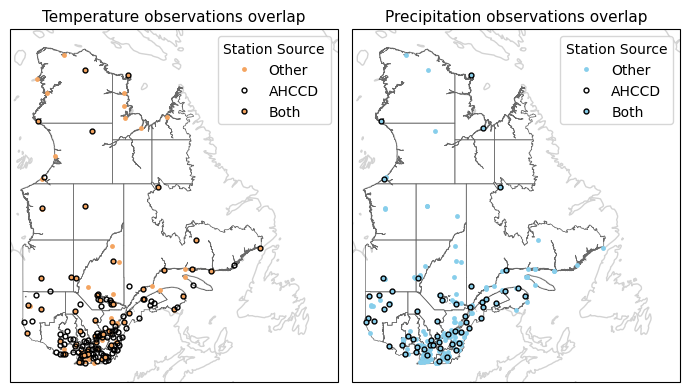

In [92]:
# === Categorization helper ===
def rounded_coords(lat, lon):
    return set(zip(np.round(lat, 2), np.round(lon, 2)))

def unzip(coords):
    if not coords:
        return np.array([]), np.array([])
    lat, lon = zip(*coords)
    return np.array(lat), np.array(lon)

def categorize(ahccd, other):
    both = ahccd & other
    ahccd_only = ahccd - both
    other_only = other - both
    return unzip(ahccd_only), unzip(other_only), unzip(both)

# === Filter function using region_gdf ===
def filter_coords_in_region(coords, region_gdf):
    points = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lat, lon in coords], crs="EPSG:4326")
    inside = gpd.sjoin(points, region_gdf, predicate="within", how="inner")
    return set((round(pt.y, 2), round(pt.x, 2)) for pt in inside.geometry)

# === Prepare and filter coordinate sets ===
ahccd_temp_coords = filter_coords_in_region(
    rounded_coords(ahccd_tas.lat.values, ahccd_tas.lon.values), region_gdf)
ahccd_precip_coords = filter_coords_in_region(
    rounded_coords(ahccd_pr.lat.values, ahccd_pr.lon.values), region_gdf)

isd_temp_coords = filter_coords_in_region(
    rounded_coords(df_isd_tas.lat.values, df_isd_tas.lon.values), region_gdf)
isd_precip_coords = filter_coords_in_region(
    rounded_coords(
        np.concatenate([df_isd_pr_day.lat.values, df_isd_pr_hr.lat.values]),
        np.concatenate([df_isd_pr_day.lon.values, df_isd_pr_hr.lon.values])
    ), region_gdf)

adjhly_coords = filter_coords_in_region(rounded_coords(adjhly_lat, adjhly_lon), region_gdf)
adjdly_coords = filter_coords_in_region(rounded_coords(adjdly_lat, adjdly_lon), region_gdf)

# === Combine and categorize ===
other_temp_coords = isd_temp_coords
other_precip_coords = isd_precip_coords | adjhly_coords | adjdly_coords

temp_ahccd, temp_other, temp_both = categorize(ahccd_temp_coords, other_temp_coords)
precip_ahccd, precip_other, precip_both = categorize(ahccd_precip_coords, other_precip_coords)

# === Plot ===
fig, (ax1, ax2) = plt.subplots(
    1, 2,
    figsize=(7, 4.5),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

# Get extent from region
minx, miny, maxx, maxy = region_gdf.total_bounds + [-1, -1, 7, 1]

for ax, (pts, color, title) in zip(
    [ax1, ax2],
    [((temp_ahccd, temp_other, temp_both), "sandybrown", "Temperature observations overlap"),
     ((precip_ahccd, precip_other, precip_both), "skyblue", "Precipitation observations overlap")]
):
    ax.set_extent([minx, maxx, miny, maxy], crs=ccrs.PlateCarree())
    ax.coastlines(color="lightgray", zorder=0)
    region_gdf.boundary.plot(ax=ax, edgecolor='dimgray', linewidth=0.5,
                              transform=ccrs.PlateCarree(), zorder=1)

    # Other (no edge)
    ax.plot(pts[1][1], pts[1][0], 'o',
            markersize=3.5, markeredgewidth=0,
            markerfacecolor=color, markeredgecolor='none',
            transform=ccrs.PlateCarree(), label="Other", zorder=2)

    # AHCCD (no fill)
    ax.plot(pts[0][1], pts[0][0], 'o',
            markersize=3.5, markerfacecolor='none', markeredgecolor='black',
            transform=ccrs.PlateCarree(), label="AHCCD", zorder=3)

    # Both (filled, edged)
    ax.plot(pts[2][1], pts[2][0], 'o',
            markersize=3.5, markerfacecolor=color, markeredgecolor='black',
            transform=ccrs.PlateCarree(), label="Both", zorder=4)

    ax.set_title(title, fontsize=11)
    ax.legend(title="Station Source", loc="upper right")

plt.tight_layout()
plt.show()


In [93]:
fig.savefig("station_overlap.svg", format="svg", bbox_inches="tight")

In [83]:
#import figanos.matplotlib as fg
#fg.scattermap(ahccd_tas.fillna(0).mean(dim="time", skipna=True), features=['coastline'])

In [84]:
#ax = fg.scattermap(ahccd_pr.mean(dim="time", skipna=True), features=['coastline'])

-CHDSD (snow thickness) dataset is omitted

-ISD v3.1 data (temperature, total daily precipitation) is filtered to have passed quality control checks and to not be missing